In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix

/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  fro

In [13]:
DATA_PATH = '../data/features/'

tran = pd.read_csv(DATA_PATH + "T.csv")
tran = tran.set_index(['ID', 'copy_num'])

ntran = pd.read_csv(DATA_PATH + "NT.csv")
ntran = ntran.set_index(['ID', 'copy_num'])


In [14]:
print("Total amout of obects (oversampled):     {}".format(tran.shape[0]+ntran.shape[0]))
print("Total amout of obects (not oversampled): {}".format(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0]))

Total amout of obects (oversampled):     62152
Total amout of obects (not oversampled): 19462


In [15]:
feats = np.array(tran.columns[2:])
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 30

The features are:
    1. amplitude
    2. beyond1st
    3. flux_percentile_ratio_mid20
    4. flux_percentile_ratio_mid35
    5. flux_percentile_ratio_mid50
    6. flux_percentile_ratio_mid65
    7. flux_percentile_ratio_mid80
    8. kurtosis
    9. max_slope
    10. median_absolute_deviation
    11. median_buffer_range_percentage
    12. pair_slope_trend
    13. pair_slope_trend_last_30
    14. percent_amplitude
    15. percent_difference_flux_percentile
    16. poly1_t1
    17. poly2_t1
    18. poly2_t2
    19. poly3_t1
    20. poly3_t2
    21. poly3_t3
    22. poly4_t1
    23. poly4_t2
    24. poly4_t3
    25. poly4_t4
    26. skew
    27. small_kurtosis
    28. std
    29. stetson_j
    30. stetson_k


In [16]:
alldf = pd.concat([tran,ntran])

# Binary Classification 
Transients and non-transients 

In [17]:
def splitTrainTest(dataframe):
    #create output dataframes
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    
    for uClass in dataframe.Class.unique():
        #get each class 
        classDf = dataframe[dataframe.Class == uClass]
        
        #unique ids
        ids = classDf.index.get_level_values('ID').unique()

        # randomly choose 25% of indices 

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #get dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [18]:
def balance(df):
    #start min at infinity 
    minNum = np.inf
    
    #find the class with the minimum amount of candidates
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
    
    #create output dataframe
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    
    #get a sample from all the classes 
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
        
    return ans

In [19]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [20]:
#copy and shuffle the data
oversampling = alldf.copy()
oversampling = oversampling.sample(frac=1)

#map all objects that are not non-transient to transient
oversampling.Class = list(map(lambda x: 'non-transient' if x=='non-transient' else 'transient', oversampling.Class))
#map transient and non-transient to binary values
oversampling['target'] = list(map(lambda x: 1 if x=='transient' else 0, oversampling.Class))

In [23]:
recall_scores = []

    
#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)



#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampled data from test set
all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


#format target variable to appropriate data type
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')
recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9151456651456652, precision=0.9157049497674883, recall=0.9151456651456652, f1_score=0.9151171150332329, total=   8.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.9195190451114622, precision=0.91964576967373, recall=0.9195190451114622, f1_score=0.9195129687462624, total=   8.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.7s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.9134784134784135, precision=0.9140845313710684, recall=0.9134784134784135, f1_score=0.9134467403082077, total=  30.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 

In [24]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.9056
Recall:    0.9044
F-score:   0.9049


In [25]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [26]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly2_t1',
      'poly2_t1':'poly1_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4'
      }[x]

In [27]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


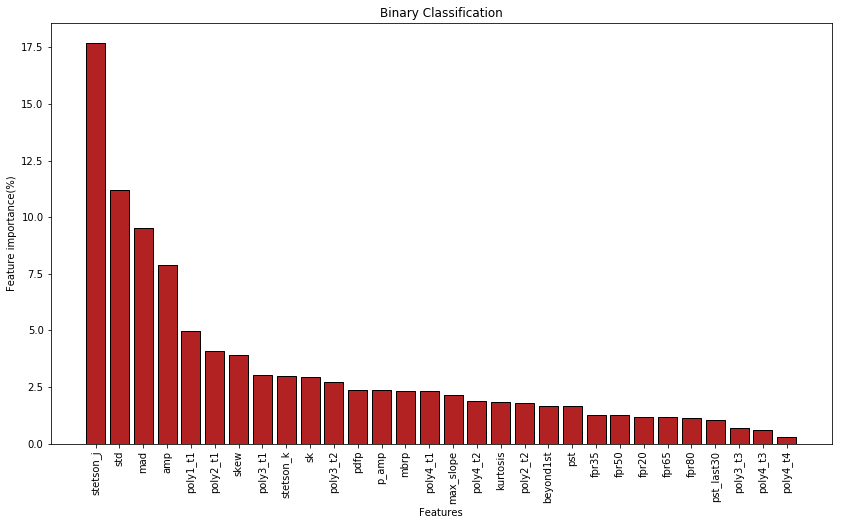

In [28]:


plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportance.pdf")

In [29]:
cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
cm

array([[3549,  216],
       [ 249,  851]])

In [30]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [31]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [33]:
print("Precision of transients:     {:.4f}".format(precisionT))
print("Recall of transients:        {:.4f}".format(recallT))
print("F-measure of transients:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of non-transients: {:.4f}".format(precisionNon))
print("Recall of non-transients:    {:.4f}".format(recallNon))
print("F-measure of non-transients: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of transients:     0.7736
Recall of transients:        0.7976
F-measure of transients:     0.7854
Precision of non-transients: 0.9426
Recall of non-transients:    0.9344
F-measure of non-transients: 0.9385


# 8-Class clasification

In [34]:
# main 6 transient classes
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']

#copy transient data
tran8 = tran.copy()

#if class is not in labels, label as other
tran8.loc[~tran8.Class.isin(labels), ['Class']] = 'Other'

#copy non transient
ntran8 = ntran.copy()

#transients and non-transients
all8 = pd.concat([tran8,ntran8])

In [35]:
# func to map labels to integer values
def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

In [36]:
# map labels to integer values
all8['target'] = list(map(lambda x: manualFact(x),all8['Class']))

# copy labeled data
oversampling = all8.copy()

#shuffle data
oversampling = oversampling.sample(frac=1)

In [37]:
recall_scores = []

#split train test class by class
all_train,all_test = splitTrainTest(oversampling)

#balance the train set
all_train= balance(all_train)



#train indices
trainIdx = all_train.index.get_level_values("ID").unique()

#remove originals that may have oversampled copies in train
all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

#remove oversampling in test
all_test = all_test[all_test.index.get_level_values('copy_num')==0]


#format stuff
all_train.target= all_train.target.astype('int')
all_test.target= all_test.target.astype('int')

model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(all_train[feats], all_train.target)
# Copy classifier
clf = grid_search

scores = precision_recall_fscore_support(
        all_test.target, clf.predict(all_test[feats]), average='weighted')


recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.7875874125874126, precision=0.7854990399005988, recall=0.7875874125874126, f1_score=0.7857555771663376, total=   6.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.7687937062937062, precision=0.768041241692728, recall=0.7687937062937062, f1_score=0.7669391258180086, total=   5.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.7881701631701632, precision=0.7860371397117597, recall=0.7881701631701632, f1_score=0.7864546609720969, total=  18.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:

In [39]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.8404
Recall:    0.7408
F-score:   0.7790


In [41]:
confMatr = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()
print(confMatr)
# 'SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient'

[[ 169   25    0    1   13    3   40   78]
 [  28  146    0    1    7    1   18   49]
 [   7    3   84    0    9    1   32   35]
 [   4    2    2   66    0    1    1  186]
 [   8   10    6    0   25    0   14    6]
 [   9    9    1    0    1   25    9  279]
 [  48   14    3    1    3    1   80  158]
 [  50    6   10    7    1   19   40 3007]]


In [42]:
normedMatrix = confMatr.copy()
# print(normedMatrix)
for i in range(len(normedMatrix)):
#     print(normedMatrix[:,i]/normedMatrix[:,i].sum())
    normedMatrix[:,i] = normedMatrix[:,i]/normedMatrix[:,i].sum()
#     print(normedMatrix[:,i])
# np.set_printoptions(suppress=True)
print(normedMatrix)
# np.set_printoptions(suppress=False)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [43]:
newMatr = []
for i in range(len(confMatr)):
    prec = confMatr[i][i]/(sum(confMatr[i,:]))
    rec = confMatr[i][i]/(sum(confMatr[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(confMatr[:,i])])

In [44]:
np.set_printoptions(suppress=True)
print('    Precision        Recall         F-score      Cover')
print(np.array(newMatr))
np.set_printoptions(suppress=False)

    Precision        Recall         F-score      Cover
[[   0.51367781    0.52321981    0.51840491  323.        ]
 [   0.584         0.67906977    0.62795699  215.        ]
 [   0.49122807    0.79245283    0.60649819  106.        ]
 [   0.2519084     0.86842105    0.39053254   76.        ]
 [   0.36231884    0.42372881    0.390625     59.        ]
 [   0.07507508    0.49019608    0.13020833   51.        ]
 [   0.25974026    0.34188034    0.29520295  234.        ]
 [   0.95764331    0.79173249    0.86682041 3798.        ]]


In [45]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = feats.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [47]:
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


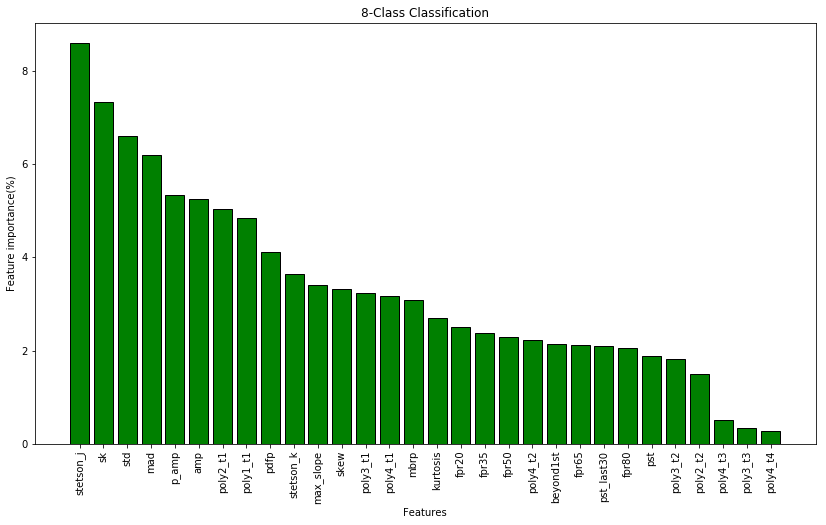

In [51]:
# from matplotlib.font_manager import FontProperties
# font = FontProperties()
# font.set_family('sans-serif')
# font.set_style('normal')

plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='#008000')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("8-Class Classification")
plt.savefig("8clasFeatImportance.pdf")